In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
from tqdm import tqdm


os.chdir('..')

from src.seg_dataset import SegDatasetCreator
from src.utils.competition_metric import ULS23_evaluator

import collections
import itertools

import numpy as np
import torch
from scipy.ndimage import binary_erosion, label
from scipy.spatial.distance import pdist, squareform

import pandas as pd
from collections import Counter
import random

from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()


In [2]:
segformer_csv_path = r'C:\Users\Lazar\OneDrive\Desktop\RU Courses\AI in Medical Imaging\project\aimi-project\SegFormer3D-main\data\uls2023_seg\uls2023_raw_data\datameta_generator\train_oversampling.csv'
data = pd.read_csv(segformer_csv_path)

data['training_path'] = data['data_path'] + "/" + data['case_name'] + '_im.pt'
data['label_path'] = data['data_path'] + "/" + data['case_name'] + '_label.pt'
data['spacings_path'] = data['data_path'] + "/" + data['case_name'] + '_label_spacings.pt'
evaluator = ULS23_evaluator()

data.head()

# FOR TESTING
# data = data.head(10)

,data_path,case_name,training_path,label_path,spacings_path
0,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_05632,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...
1,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_04414,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...
2,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_05669,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...
3,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_02524,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...
4,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_02824,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...


In [ ]:
def calculate_lesion_sizes(label_path, spacings_path):
    label_array = torch.load(label_path, weights_only=False).squeeze()
    # Spacing should be reversed in order to align the z axis in the image and spacings arrays but w/e  
    voxel_spacing = np.array(torch.load(spacings_path, weights_only=False)[:3])
    _, _, long_axis_points, short_axis_points = evaluator.long_and_short_axis_diameters(label_array)

    if long_axis_points is None:
        # No idea why this happens but its only a few cases and i think we can ignore it
        return (0, 0)
    
    p1_long, p2_long = long_axis_points
    p1_short, p2_short = short_axis_points

    vec_long = (p2_long - p1_long) * voxel_spacing
    vec_short = (p2_short - p1_short) * voxel_spacing

    # Compute Euclidean distances (in mm)
    label_long_mm = np.linalg.norm(vec_long)
    label_short_mm = np.linalg.norm(vec_short)
    
    return (label_long_mm, label_short_mm)

In [6]:
os.chdir(r'C:\Users\Lazar\OneDrive\Desktop\RU Courses\AI in Medical Imaging\project\aimi-project\SegFormer3D-main\data\uls2023_seg\uls2023_raw_data')       

data[['long_axis_mm', 'short_axis_mm']] = data.progress_apply(lambda row: pd.Series(calculate_lesion_sizes(row['label_path'], row['spacings_path'])), axis=1)

  0%|          | 0/4753 [00:00<?, ?it/s]

(64, 128, 128)
(64, 128, 128)


  0%|          | 3/4753 [00:00<22:01,  3.59it/s]

(64, 128, 128)


  0%|          | 4/4753 [00:01<22:00,  3.60it/s]

(64, 128, 128)
(64, 128, 128)
(64, 128, 128)


  0%|          | 6/4753 [00:01<19:33,  4.04it/s]


KeyboardInterrupt: 

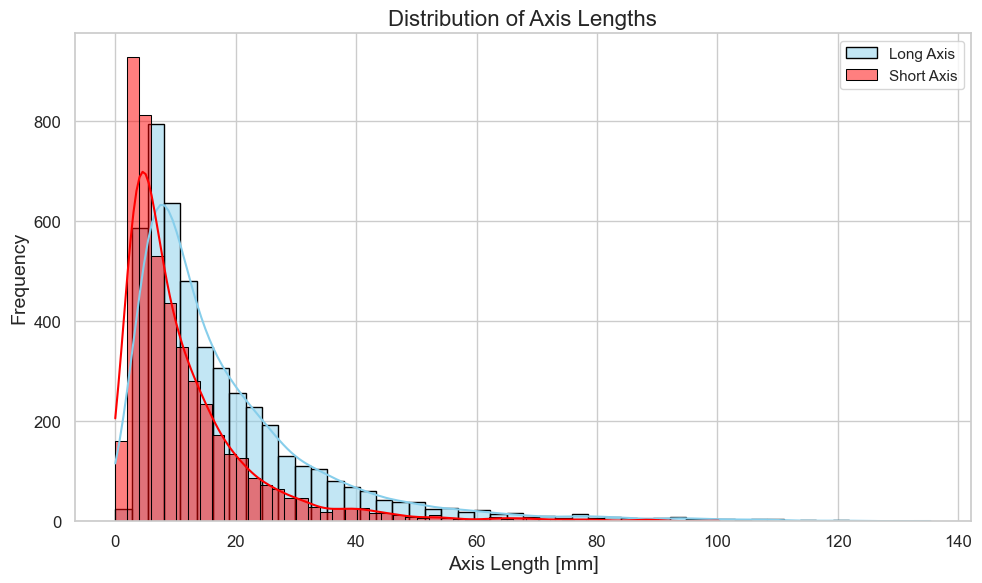

In [23]:
BINS = 50

# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['long_axis_mm'], bins=BINS, kde=True, color='skyblue', edgecolor='black', label='Long Axis')
sns.histplot(data['short_axis_mm'], bins=BINS, kde=True, color='red', edgecolor='black', label='Short Axis')


# Customize the plot
plt.title("Distribution of Axis Lengths", fontsize=16)
plt.xlabel("Axis Length [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
long_axis_weigth = 0.8
short_axis_weigth = 0.2

data['combined_size'] = data.progress_apply(lambda row: row['long_axis_mm']*long_axis_weigth + row['short_axis_mm']*short_axis_weigth, axis=1)

data

100%|██████████| 4753/4753 [00:00<00:00, 97007.03it/s]


,data_path,case_name,training_path,label_path,spacings_path,long_axis_mm,short_axis_mm,combined_size
0,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_05632,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,12.992778,11.136667,12.621556
1,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_04414,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,56.287952,43.118941,53.654150
2,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_05669,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,36.451607,29.839949,35.129276
3,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_02524,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,19.597244,9.798622,17.637519
4,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_02824,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,4.870943,3.089975,4.514750
...,...,...,...,...,...,...,...,...
4748,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_04116,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,9.546875,5.592833,8.756067
4749,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_00068,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,22.203603,13.601471,20.483177
4750,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_02643,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,12.476602,8.023898,11.586061
4751,../../../data/uls2023_seg/ULS2023_Training_Dat...,MIX_01888,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,../../../data/uls2023_seg/ULS2023_Training_Dat...,21.332560,10.933035,19.252655


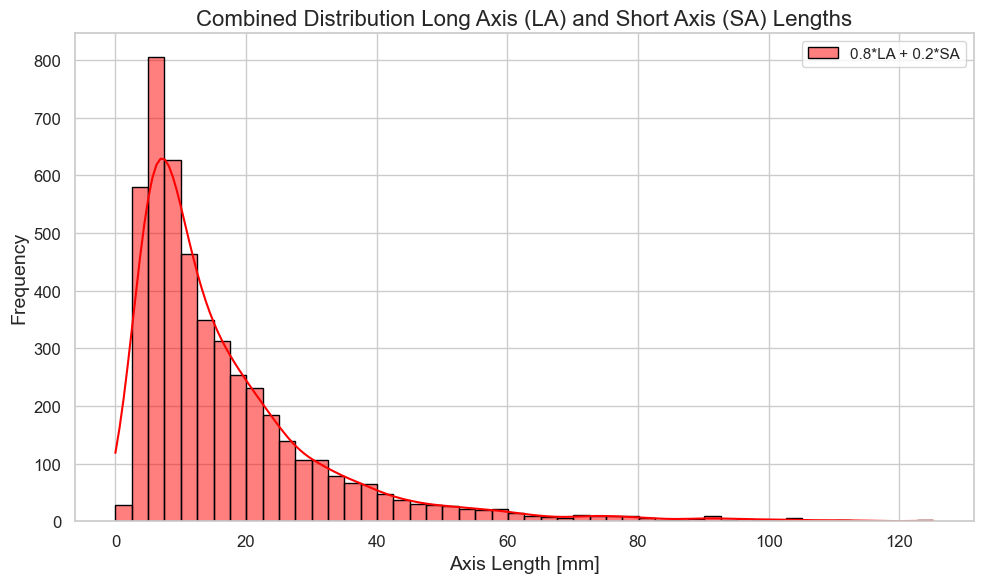

In [25]:
BINS = 50

# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['combined_size'], bins=BINS, kde=True, color='red', edgecolor='black', label=f'{long_axis_weigth}*LA + {short_axis_weigth}*SA')


# Customize the plot
plt.title("Combined Distribution Long Axis (LA) and Short Axis (SA) Lengths", fontsize=16)
plt.xlabel("Axis Length [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

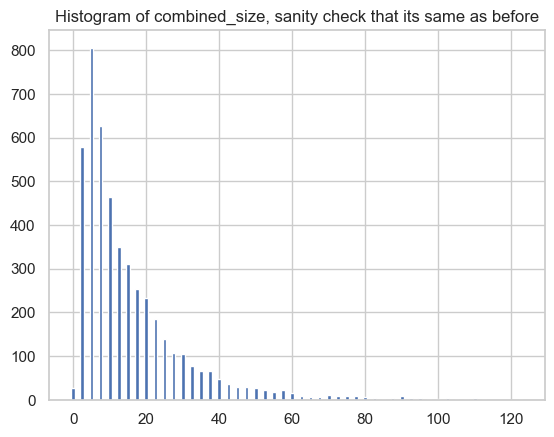

In [40]:
np.random.seed(42)

STRENGTH = 1.2

combined_axis_size = data['combined_size'].values

mean = np.mean(combined_axis_size)
std = np.std(combined_axis_size)

# Bin the data
hist, bin_edges = np.histogram(combined_axis_size, bins=50)
# Sanity check
plt.bar(bin_edges[:-1],hist,width=1)
plt.title("Histogram of combined_size, sanity check that its same as before")
plt.show()

# Assign each value to a bin
bin_indices = np.digitize(combined_axis_size, bin_edges) - 1
bin_counts = Counter(bin_indices)

bin_probabilities = 1 / np.array(list(bin_counts.values()))
bin_probabilities /= np.sum(bin_probabilities)
bin_probabilities = dict(zip(bin_counts.keys(), bin_probabilities))

# Inverse frequency weights (with temperature control)
weights = np.array([bin_probabilities[i] for i in bin_indices])
weights = weights ** STRENGTH
weights = weights / np.sum(weights)

# Sample more from rare bins
oversample_count = len(data) // 2
sampled_indices = np.random.choice(len(data), size=oversample_count, replace=True, p=weights)
# Get the sampled rows
oversampled_rows = data.iloc[sampled_indices]

# Keep only those outside 1 std from the mean
outside_std_mask = (oversampled_rows['combined_size'] < mean - std) | \
                   (oversampled_rows['combined_size'] > mean + std)
filtered_oversampled_rows = oversampled_rows[outside_std_mask]

# Append to the original DataFrame
combined_oversampled_data = pd.concat([data, filtered_oversampled_rows], ignore_index=True)

# Optional: shuffle
combined_oversampled_data = combined_oversampled_data.sample(frac=1).reset_index(drop=True)


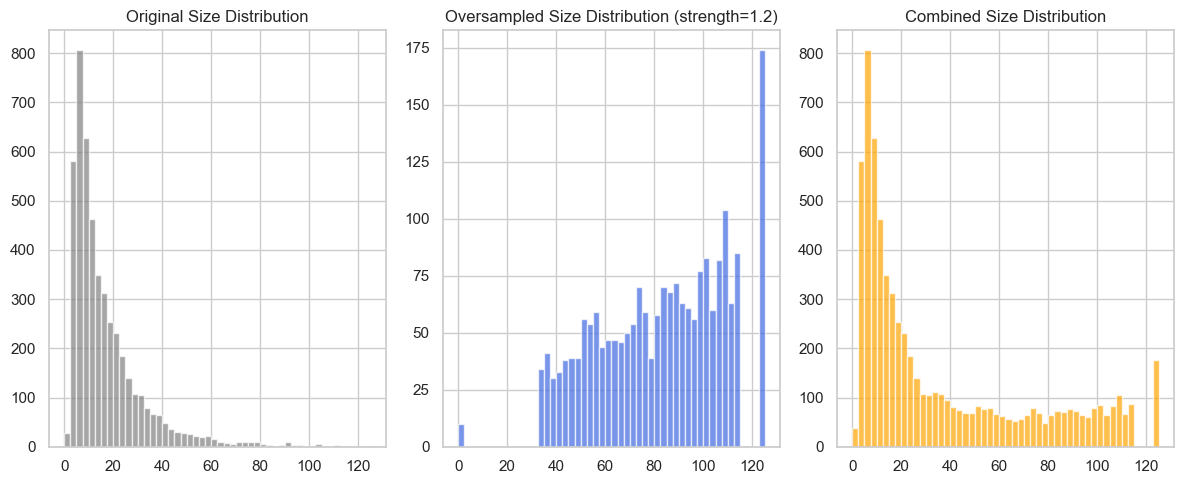

In [41]:
# Plot original and oversampled distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(combined_axis_size, bins=BINS, color='gray', alpha=0.7)
plt.title("Original Size Distribution")

plt.subplot(1, 3, 2)
plt.hist(filtered_oversampled_rows['combined_size'].values, bins=BINS, color='royalblue', alpha=0.7)
plt.title(f"Oversampled Size Distribution (strength={STRENGTH})")

plt.subplot(1, 3, 3)
plt.hist(combined_oversampled_data['combined_size'].values, bins=BINS, color='orange', alpha=0.7)
plt.title("Combined Size Distribution")

plt.tight_layout()
plt.show()

In [42]:
# Plot original and oversampled distributions
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 3, 1)
# plt.hist(combined_axis_size, bins=BINS, color='gray', alpha=0.7)
sns.histplot(combined_axis_size, bins=BINS, kde=True, color='#CB0404', edgecolor='black')
plt.ylim([0, 850])
plt.title("Original Lesion Size Distribution", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.tight_layout()
plt.savefig('./orgi_size.pdf')
plt.clf()
# plt.subplot(1, 3, 2)
# plt.hist(filtered_oversampled_rows['combined_size'].values, bins=BINS, color='royalblue', alpha=0.7)
sns.histplot(filtered_oversampled_rows['combined_size'].values, bins=BINS, kde=True, color='#F4631E', edgecolor='black', )
plt.title(f"Oversampled Lesion Size Distribution (strength={STRENGTH})", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.ylim([0, 850])
plt.tight_layout()
plt.savefig('./sample_size.pdf')
plt.clf()
# plt.subplot(1, 3, 3)
# plt.hist(combined_oversampled_data['combined_size'].values, bins=BINS, color='orange', alpha=0.7)
sns.histplot(combined_oversampled_data['combined_size'].values, bins=BINS, kde=True, color='#309898', edgecolor='black')
plt.title("Combined Lesion Size Distribution", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.ylim([0, 850])
plt.tight_layout()
plt.savefig('./combined_size.pdf')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [43]:
print(f"Number of oversampled data points: {len(filtered_oversampled_rows)}, which is {len(filtered_oversampled_rows)/len(data)*100}% of the original data!")

print(os.getcwd())

combined_oversampled_data.head()


combined_oversampled_data[['data_path', 'case_name']].to_csv('./datameta_generator/testing.csv', index=False)

Number of oversampled data points: 2065, which is 43.446244477172314% of the original data!
C:\Users\Lazar\OneDrive\Desktop\RU Courses\AI in Medical Imaging\project\aimi-project\SegFormer3D-main\data\uls2023_seg\uls2023_raw_data
